#  https://github.com/byschii/ecg-segmentation/tree/main
### Functions for reading the data and preprocessing from this repository.
### Comparing LSTM results to UNET

In [1]:
import os
import numpy as np
import wfdb
import torch
from torch import nn
from tqdm import tqdm
from customLib.preprocess import norm_min_max
from customLib.lobachevsky import EGCSignal, get_class_weights
from customLib.dataset import split_dataset
from models.datasets import ECGDataset

In [2]:
LEADS = ['avf', 'avl', 'avr', 'i', 'ii', 'iii', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6']

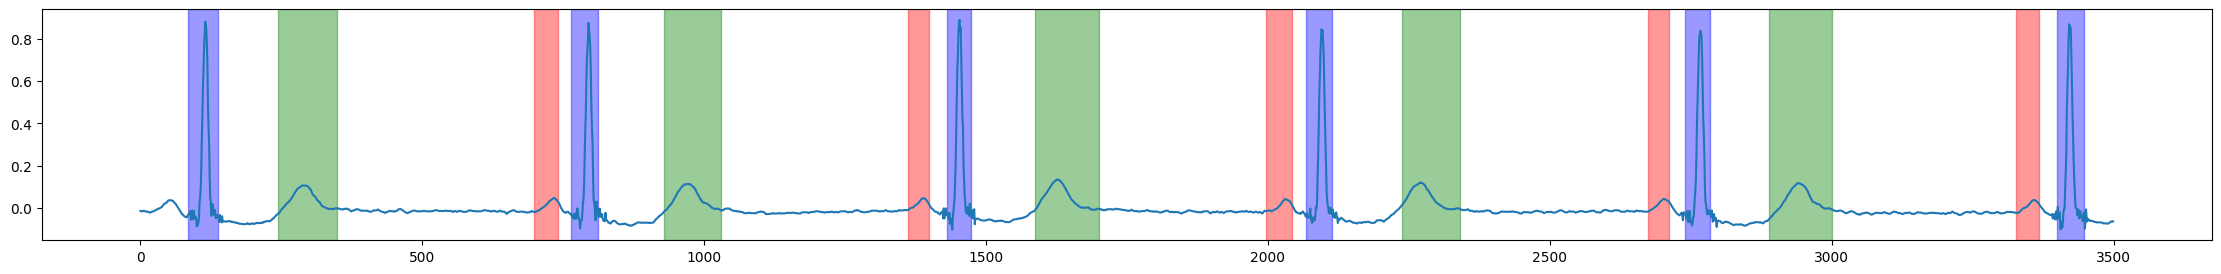

In [3]:
EGCSignal.from_index_and_lead(1, LEADS[0]).plot_with_segments()

### Data preprocessing
Change to the original notebook - from to_categorical to one_hot by hand because I am using just torch

Pytorch docs - CrossEntropyLoss criterion is generally better when `target` contains class indices, as this follows for optimized computation. Therefore I will not use one-hot encoding here. 

In [13]:
def one_hot(categories, num_classes):
    return np.eye(num_classes)[categories]

In [ ]:
import random
import copy

ECG_SIZE=512
X = []
Y = []
for ecg_index in range(1,200):
    print(ecg_index, end = ', ')
    for lead in LEADS:
        try:
            start = 0
            s = EGCSignal.from_index_and_lead(ecg_index, lead)
            for ecg_part in range(0, 4):
                s_copy = copy.deepcopy(s)

                span = ECG_SIZE
                start += random.randint(0, 50) + span
                s_copy._cut_beginning(start)
                s_copy._cut_end(span)

                # append the signal to X, also adding a new dimension
                X.append(s_copy.signal)
                # append the category to Y
                Y.append((s_copy.categories + 1).astype(int))
        except Exception as e:
            print(e)

X = np.array(X)
X = np.expand_dims(X, axis=2)
Y = np.array(Y)

In [5]:
x_train, y_train, x_test, y_test, x_val, y_val = split_dataset(X, Y, is_validation_set=True, shuffle=True)

Total ECGs: 9432


c:\Users\patry\OneDrive\Elearning - PG\WETI\masters-thesis\customLib\dataset.py:34: UserWarning: Path is not specified. The dataset is not being saved.
  warnings.warn("Path is not specified. The dataset is not being saved.")


### Model - I am going to use a LSTM network

In [6]:
from torch import nn

class SegRNN(nn.Module):
    def __init__(self, input_dim, hidden_size, num_layers, out_size=4, dropout=0.3):
        super(SegRNN, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_size, batch_first=True, bidirectional=True, num_layers=num_layers, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(2*hidden_size, 2*hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(2*hidden_size, 2*hidden_size),
            nn.ReLU(inplace=True),
        )
        self.output = nn.Linear(2*hidden_size, out_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return self.output(out)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SegRNN(input_dim=1, hidden_size=256, num_layers=2, dropout=0.3)
model.to(device)

class_weights = torch.Tensor(get_class_weights(y_train[:10], normalize=True)).to(device)
print("Class weights : ", class_weights)


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

train_dataset = ECGDataset(x_train, y_train)
validation_dataset = ECGDataset(x_val, y_val)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=50)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=50)


Class weights :  tensor([0.0684, 0.3121, 0.2559, 0.3636], device='cuda:0')


In [8]:
from torchmetrics.classification import JaccardIndex #, MulticlassJaccardIndex
from torchmetrics.classification import BinaryF1Score, ConfusionMatrix, Accuracy

def calculate_metrics(y: np.array, pred: np.array, verbose=False):
    WAVE_TO_COLUMN = {
        "None": 0,
        "P": 1,
        "QRS": 2,
        "T": 3,
    }

    WAVE_METRICS = {
        "None": {},
        "P": {},
        "QRS": {},
        "T": {},
    }

    for wave_name, column_index in WAVE_TO_COLUMN.items():
        metrics = {
            "F1_score": 0,
            "confusion_matrix": ConfusionMatrix(task="binary", num_classes=2),
            "TPR": 0,
            "FPR": 0,
            "TNR": 0,
            "FNR": 0,
            "mean_iou": JaccardIndex(task="binary"),
            "weighted_accuracy": 0,
        }

        wave_test = (y == column_index).astype(int)
        wave_pred = (np.argmax(pred, axis=1) == column_index).astype(int)

        weight_class_1 = np.sum(y == column_index)
        weight_class_0 = np.sum(y != column_index)

        wave_test = torch.tensor(wave_test)
        wave_pred = torch.tensor(wave_pred)

        metrics["F1_score"] = BinaryF1Score()(wave_pred, wave_test).item()

        metrics["mean_iou"].update(wave_pred, wave_test)
        metrics["mean_iou"] = metrics["mean_iou"].compute().item()

        metrics["confusion_matrix"].update(wave_pred, wave_test)
        final_conf_matrix = metrics["confusion_matrix"].compute()

        tp = final_conf_matrix[1, 1].item()
        tn = final_conf_matrix[0, 0].item()
        fp = final_conf_matrix[0, 1].item()
        fn = final_conf_matrix[1, 0].item()

        metrics["TPR"] = tp / (tp + fn) if (tp + fn) > 0 else 0
        metrics["FPR"] = fp / (fp + tn) if (fp + tn) > 0 else 0
        metrics["TNR"] = tn / (tn + fp) if (tn + fp) > 0 else 0
        metrics["FNR"] = fn / (fn + tp) if (fn + tp) > 0 else 0

        weighted_accuracy = (
            (metrics["TPR"] * weight_class_1 + metrics["TNR"] * weight_class_0) /
            (weight_class_1 + weight_class_0)
        )

        metrics["weighted_accuracy"] = weighted_accuracy
 
        WAVE_METRICS[wave_name] = metrics
    
    if verbose:
        print("\n" + "="*50)
        print(f"{'Wave Type':<10} {'F1 Score':<10} {'Mean IoU':<10} {'TPR':<8} {'FPR':<8} {'TNR':<8} {'FNR':<8} {'Weighted Accuracy':<18}")
        print("-"*50)
        for wave_name, metrics in WAVE_METRICS.items():
            print(f"{wave_name:<10} "
                  f"{metrics['F1_score']:<10.4f} "
                  f"{metrics['mean_iou']:<10.4f} "
                  f"{metrics['TPR']:<8.4f} "
                  f"{metrics['FPR']:<8.4f} "
                  f"{metrics['TNR']:<8.4f} "
                  f"{metrics['FNR']:<8.4f}"
                  f"{metrics['weighted_accuracy']:<8.4f}")
        print("="*50 + "\n")
    
    return WAVE_METRICS



In [9]:
def validate(model):
    model.eval()
    running_vloss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for i, (inputs, labels) in tqdm(enumerate(validation_loader), total=len(validation_loader)):
            inputs = inputs.to(device)
            labels = labels.type(dtype=torch.LongTensor)
            labels = labels.to(device)

            outputs = model(inputs)

            outputs = outputs.view(-1, outputs.shape[-1])
            labels = labels.view(-1)

            loss = criterion(outputs, labels)
            running_vloss += loss.item()

            total += labels.shape[0]
            correct += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

    print(f"Validation loss: {round(running_vloss/len(validation_loader), 6)}")
    print(f"Average Wave Accuracy: {round(correct / total * 100, 4)}%\n")

def train(model, epochs):
    for epoch in range(epochs):
        total = correct = running_loss = 0 
        model.train()

        all_outputs = []
        all_labels = []
        best_acc = 0.0

        print(f"==========Epoch [{epoch+1}/{epochs}]===========")
        for i, (inputs, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
            inputs = inputs.to(device)
            labels = labels.type(dtype=torch.LongTensor)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)

            outputs = outputs.view(-1, outputs.shape[-1])
            labels = labels.view(-1)
            
            loss = criterion(outputs, labels)

            loss.backward()
            running_loss += loss.item()

            total += labels.shape[0]
            correct += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

            optimizer.step()

            all_outputs.extend(outputs.cpu().detach().numpy())
            all_labels.extend(labels.cpu().detach().numpy())
        
        all_outputs = np.array(all_outputs) #(169984, 4)
        all_labels = np.array(all_labels) # (169984,)

        average_wave_accum = round(correct / total * 100, 4)

        print(f"\nTrain loss: {round(running_loss/len(train_loader), 6)}")
        print(f"Average Wave Accuracy: {average_wave_accum}%")
        calculate_metrics(all_labels, all_outputs, verbose=True)

        if(best_acc < average_wave_accum):
            best_acc = average_wave_accum
            torch.save(model.state_dict(), f"./checkpoints/segmentation/lstm/epoch_{epoch+1}_acc_{average_wave_accum:.2f}.pt")

        if validation_loader is not None:
            validate(model)

In [34]:
train(model, 50)

==========Epoch [1/50]===========


100%|██████████| 151/151 [01:21<00:00,  1.86it/s]



Train loss: 1.033833
Average Wave Accuracy: 61.7282%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.7581     0.6104     0.9775   0.8808   0.1192   0.0225  0.6293  
P          0.3594     0.2190     0.2395   0.0116   0.9884   0.7605  0.9058  
QRS        0.0852     0.0445     0.0465   0.0114   0.9886   0.9535  0.7996  
T          0.0122     0.0061     0.0065   0.0066   0.9934   0.9935  0.8998  



100%|██████████| 19/19 [00:03<00:00,  5.21it/s]


Validation loss: 0.810213
Average Wave Accuracy: 69.0557%

==========Epoch [2/50]===========


100%|██████████| 151/151 [01:28<00:00,  1.71it/s]



Train loss: 0.711455
Average Wave Accuracy: 72.827%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.8158     0.6889     0.9188   0.4889   0.5111   0.0812  0.7534  
P          0.8583     0.7517     0.8489   0.0160   0.9840   0.1511  0.9691  
QRS        0.5008     0.3340     0.4260   0.0691   0.9309   0.5740  0.8296  
T          0.0611     0.0315     0.0328   0.0043   0.9957   0.9672  0.9044  



100%|██████████| 19/19 [00:04<00:00,  4.59it/s]


Validation loss: 0.583698
Average Wave Accuracy: 77.0962%

==========Epoch [3/50]===========


100%|██████████| 151/151 [01:31<00:00,  1.64it/s]



Train loss: 0.466792
Average Wave Accuracy: 81.7874%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.8623     0.7579     0.8853   0.2464   0.7536   0.1147  0.8319  
P          0.8820     0.7890     0.8711   0.0129   0.9871   0.1289  0.9743  
QRS        0.7265     0.5705     0.6999   0.0569   0.9431   0.3001  0.8943  
T          0.6306     0.4605     0.5829   0.0278   0.9722   0.4171  0.9353  



100%|██████████| 19/19 [00:04<00:00,  4.65it/s]


Validation loss: 0.40314
Average Wave Accuracy: 84.2963%

==========Epoch [4/50]===========


100%|██████████| 151/151 [01:29<00:00,  1.68it/s]



Train loss: 0.42557
Average Wave Accuracy: 83.6302%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.8752     0.7782     0.9020   0.2331   0.7669   0.0980  0.8472  
P          0.8820     0.7889     0.8692   0.0126   0.9874   0.1308  0.9743  
QRS        0.7569     0.6088     0.7203   0.0459   0.9541   0.2797  0.9072  
T          0.6811     0.5164     0.6318   0.0234   0.9766   0.3682  0.9439  



100%|██████████| 19/19 [00:04<00:00,  4.60it/s]


Validation loss: 0.380378
Average Wave Accuracy: 85.2627%

==========Epoch [5/50]===========


100%|██████████| 151/151 [01:31<00:00,  1.64it/s]



Train loss: 0.390983
Average Wave Accuracy: 84.8621%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.8835     0.7913     0.9047   0.2099   0.7901   0.0953  0.8582  
P          0.8915     0.8043     0.8809   0.0118   0.9882   0.1191  0.9764  
QRS        0.7782     0.6370     0.7492   0.0442   0.9558   0.2508  0.9143  
T          0.7108     0.5513     0.6698   0.0225   0.9775   0.3302  0.9483  



100%|██████████| 19/19 [00:04<00:00,  4.54it/s]


Validation loss: 0.372082
Average Wave Accuracy: 85.6134%

==========Epoch [6/50]===========


100%|██████████| 151/151 [01:32<00:00,  1.64it/s]



Train loss: 0.373613
Average Wave Accuracy: 85.4401%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.8858     0.7951     0.9052   0.2029   0.7971   0.0948  0.8613  
P          0.8947     0.8095     0.8837   0.0114   0.9886   0.1163  0.9771  
QRS        0.7995     0.6660     0.7739   0.0407   0.9593   0.2261  0.9221  
T          0.7113     0.5519     0.6723   0.0228   0.9772   0.3277  0.9483  



100%|██████████| 19/19 [00:04<00:00,  4.58it/s]


Validation loss: 0.348932
Average Wave Accuracy: 86.2273%

==========Epoch [7/50]===========


100%|██████████| 151/151 [01:31<00:00,  1.64it/s]



Train loss: 0.468207
Average Wave Accuracy: 82.2943%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.8637     0.7601     0.8981   0.2660   0.7340   0.1019  0.8315  
P          0.8254     0.7027     0.7957   0.0164   0.9836   0.2043  0.9629  
QRS        0.7542     0.6054     0.7118   0.0441   0.9559   0.2882  0.9069  
T          0.6792     0.5142     0.6187   0.0213   0.9787   0.3813  0.9446  



100%|██████████| 19/19 [00:04<00:00,  4.60it/s]


Validation loss: 1.099961
Average Wave Accuracy: 59.6962%

==========Epoch [8/50]===========


100%|██████████| 151/151 [01:30<00:00,  1.66it/s]



Train loss: 0.797385
Average Wave Accuracy: 69.6579%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.7931     0.6572     0.9424   0.6358   0.3642   0.0576  0.7078  
P          0.7385     0.5855     0.6581   0.0154   0.9846   0.3419  0.9486  
QRS        0.3653     0.2234     0.2506   0.0305   0.9695   0.7494  0.8253  
T          0.2356     0.1335     0.1440   0.0082   0.9918   0.8560  0.9114  



100%|██████████| 19/19 [00:04<00:00,  4.67it/s]


Validation loss: 0.509192
Average Wave Accuracy: 80.1413%

==========Epoch [9/50]===========


100%|██████████| 151/151 [01:28<00:00,  1.70it/s]



Train loss: 0.420087
Average Wave Accuracy: 83.0519%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.8657     0.7632     0.8877   0.2390   0.7610   0.1123  0.8363  
P          0.8738     0.7759     0.8534   0.0124   0.9876   0.1466  0.9728  
QRS        0.7792     0.6383     0.7549   0.0459   0.9541   0.2451  0.9142  
T          0.6484     0.4797     0.6054   0.0274   0.9726   0.3946  0.9378  



100%|██████████| 19/19 [00:03<00:00,  5.39it/s]


Validation loss: 0.378673
Average Wave Accuracy: 84.4001%

==========Epoch [10/50]===========


100%|██████████| 151/151 [01:30<00:00,  1.68it/s]



Train loss: 0.338204
Average Wave Accuracy: 86.1962%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.8882     0.7989     0.8994   0.1843   0.8157   0.1006  0.8655  
P          0.8925     0.8058     0.8792   0.0113   0.9887   0.1208  0.9766  
QRS        0.8291     0.7080     0.8190   0.0393   0.9607   0.1810  0.9322  
T          0.7240     0.5673     0.6977   0.0241   0.9759   0.3023  0.9496  



100%|██████████| 19/19 [00:04<00:00,  4.58it/s]


Validation loss: 0.315203
Average Wave Accuracy: 87.3126%

==========Epoch [11/50]===========


100%|██████████| 151/151 [01:25<00:00,  1.77it/s]



Train loss: 0.302788
Average Wave Accuracy: 87.6606%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.8991     0.8167     0.9073   0.1625   0.8375   0.0927  0.8789  
P          0.9005     0.8191     0.8891   0.0106   0.9894   0.1109  0.9783  
QRS        0.8489     0.7375     0.8419   0.0355   0.9645   0.1581  0.9399  
T          0.7622     0.6158     0.7433   0.0217   0.9783   0.2567  0.9560  



100%|██████████| 19/19 [00:03<00:00,  5.31it/s]


Validation loss: 0.275773
Average Wave Accuracy: 88.88%

==========Epoch [12/50]===========


100%|██████████| 151/151 [01:19<00:00,  1.89it/s]



Train loss: 0.299166
Average Wave Accuracy: 87.8625%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9008     0.8195     0.9101   0.1618   0.8382   0.0899  0.8809  
P          0.8999     0.8180     0.8886   0.0107   0.9893   0.1114  0.9782  
QRS        0.8526     0.7430     0.8433   0.0339   0.9661   0.1567  0.9415  
T          0.7650     0.6194     0.7445   0.0211   0.9789   0.2555  0.9567  



100%|██████████| 19/19 [00:03<00:00,  5.21it/s]


Validation loss: 0.262756
Average Wave Accuracy: 89.3444%

==========Epoch [13/50]===========


100%|██████████| 151/151 [01:20<00:00,  1.87it/s]



Train loss: 0.271629
Average Wave Accuracy: 88.9104%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9085     0.8323     0.9155   0.1464   0.8536   0.0845  0.8904  
P          0.9091     0.8334     0.8991   0.0098   0.9902   0.1009  0.9802  
QRS        0.8654     0.7628     0.8594   0.0318   0.9682   0.1406  0.9464  
T          0.7913     0.6547     0.7747   0.0192   0.9808   0.2253  0.9613  



100%|██████████| 19/19 [00:03<00:00,  5.27it/s]


Validation loss: 0.25447
Average Wave Accuracy: 89.6522%

==========Epoch [14/50]===========


100%|██████████| 151/151 [01:19<00:00,  1.90it/s]



Train loss: 0.260893
Average Wave Accuracy: 89.282%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9113     0.8371     0.9179   0.1414   0.8586   0.0821  0.8938  
P          0.9109     0.8364     0.9017   0.0097   0.9903   0.0983  0.9805  
QRS        0.8704     0.7705     0.8654   0.0309   0.9691   0.1346  0.9483  
T          0.8006     0.6675     0.7835   0.0182   0.9818   0.2165  0.9630  



100%|██████████| 19/19 [00:03<00:00,  5.27it/s]


Validation loss: 0.252088
Average Wave Accuracy: 89.6679%

==========Epoch [15/50]===========


100%|██████████| 151/151 [01:21<00:00,  1.86it/s]



Train loss: 0.25372
Average Wave Accuracy: 89.5536%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9134     0.8405     0.9191   0.1370   0.8630   0.0809  0.8964  
P          0.9132     0.8402     0.9049   0.0096   0.9904   0.0951  0.9810  
QRS        0.8733     0.7751     0.8694   0.0305   0.9695   0.1306  0.9494  
T          0.8079     0.6776     0.7920   0.0177   0.9823   0.2080  0.9643  



100%|██████████| 19/19 [00:03<00:00,  4.88it/s]


Validation loss: 0.242565
Average Wave Accuracy: 90.0639%

==========Epoch [16/50]===========


100%|██████████| 151/151 [01:20<00:00,  1.87it/s]



Train loss: 0.247778
Average Wave Accuracy: 89.8039%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9153     0.8438     0.9208   0.1335   0.8665   0.0792  0.8987  
P          0.9149     0.8431     0.9066   0.0093   0.9907   0.0934  0.9814  
QRS        0.8766     0.7803     0.8734   0.0299   0.9701   0.1266  0.9507  
T          0.8133     0.6854     0.7978   0.0172   0.9828   0.2022  0.9653  



100%|██████████| 19/19 [00:03<00:00,  5.28it/s]


Validation loss: 0.246652
Average Wave Accuracy: 89.8626%

==========Epoch [17/50]===========


100%|██████████| 151/151 [01:18<00:00,  1.92it/s]



Train loss: 0.241891
Average Wave Accuracy: 90.0443%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9172     0.8471     0.9216   0.1289   0.8711   0.0784  0.9011  
P          0.9163     0.8456     0.9093   0.0093   0.9907   0.0907  0.9817  
QRS        0.8792     0.7845     0.8773   0.0297   0.9703   0.1227  0.9516  
T          0.8200     0.6949     0.8065   0.0168   0.9832   0.1935  0.9664  



100%|██████████| 19/19 [00:03<00:00,  5.28it/s]


Validation loss: 0.237033
Average Wave Accuracy: 90.3309%

==========Epoch [18/50]===========


100%|██████████| 151/151 [01:20<00:00,  1.88it/s]



Train loss: 0.237826
Average Wave Accuracy: 90.2155%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9186     0.8494     0.9231   0.1271   0.8729   0.0769  0.9028  
P          0.9180     0.8484     0.9111   0.0092   0.9908   0.0889  0.9820  
QRS        0.8812     0.7877     0.8791   0.0291   0.9709   0.1209  0.9525  
T          0.8232     0.6995     0.8091   0.0164   0.9836   0.1909  0.9671  



100%|██████████| 19/19 [00:03<00:00,  4.96it/s]


Validation loss: 0.23692
Average Wave Accuracy: 90.3997%

==========Epoch [19/50]===========


100%|██████████| 151/151 [01:18<00:00,  1.91it/s]



Train loss: 0.234741
Average Wave Accuracy: 90.3402%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9196     0.8511     0.9238   0.1250   0.8750   0.0762  0.9040  
P          0.9182     0.8489     0.9115   0.0092   0.9908   0.0885  0.9821  
QRS        0.8823     0.7894     0.8806   0.0290   0.9710   0.1194  0.9529  
T          0.8277     0.7061     0.8144   0.0161   0.9839   0.1856  0.9679  



100%|██████████| 19/19 [00:03<00:00,  5.39it/s]


Validation loss: 0.233348
Average Wave Accuracy: 90.4823%

==========Epoch [20/50]===========


100%|██████████| 151/151 [01:18<00:00,  1.92it/s]



Train loss: 0.233036
Average Wave Accuracy: 90.3948%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9200     0.8519     0.9243   0.1244   0.8756   0.0757  0.9045  
P          0.9194     0.8508     0.9130   0.0091   0.9909   0.0870  0.9823  
QRS        0.8821     0.7890     0.8801   0.0290   0.9710   0.1199  0.9528  
T          0.8298     0.7091     0.8165   0.0159   0.9841   0.1835  0.9683  



100%|██████████| 19/19 [00:03<00:00,  5.20it/s]


Validation loss: 0.231316
Average Wave Accuracy: 90.4081%

==========Epoch [21/50]===========


100%|██████████| 151/151 [01:19<00:00,  1.91it/s]



Train loss: 0.227514
Average Wave Accuracy: 90.6059%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9217     0.8547     0.9252   0.1209   0.8791   0.0748  0.9065  
P          0.9202     0.8522     0.9140   0.0090   0.9910   0.0860  0.9825  
QRS        0.8855     0.7946     0.8840   0.0282   0.9718   0.1160  0.9542  
T          0.8339     0.7151     0.8233   0.0158   0.9842   0.1767  0.9689  



100%|██████████| 19/19 [00:03<00:00,  5.06it/s]


Validation loss: 0.228619
Average Wave Accuracy: 90.584%

==========Epoch [22/50]===========


100%|██████████| 151/151 [01:19<00:00,  1.90it/s]



Train loss: 0.224697
Average Wave Accuracy: 90.7135%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9225     0.8562     0.9261   0.1195   0.8805   0.0739  0.9076  
P          0.9209     0.8535     0.9149   0.0089   0.9911   0.0851  0.9827  
QRS        0.8868     0.7966     0.8857   0.0281   0.9719   0.1143  0.9546  
T          0.8363     0.7187     0.8250   0.0155   0.9845   0.1750  0.9694  



100%|██████████| 19/19 [00:03<00:00,  5.23it/s]


Validation loss: 0.230786
Average Wave Accuracy: 90.4945%

==========Epoch [23/50]===========


100%|██████████| 151/151 [01:18<00:00,  1.92it/s]



Train loss: 0.221434
Average Wave Accuracy: 90.856%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9237     0.8582     0.9268   0.1171   0.8829   0.0732  0.9090  
P          0.9215     0.8544     0.9157   0.0089   0.9911   0.0843  0.9828  
QRS        0.8884     0.7992     0.8878   0.0278   0.9722   0.1122  0.9552  
T          0.8403     0.7246     0.8298   0.0152   0.9848   0.1702  0.9701  



100%|██████████| 19/19 [00:03<00:00,  5.28it/s]


Validation loss: 0.22677
Average Wave Accuracy: 90.7207%

==========Epoch [24/50]===========


100%|██████████| 151/151 [01:18<00:00,  1.92it/s]



Train loss: 0.218727
Average Wave Accuracy: 90.9686%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9246     0.8598     0.9277   0.1158   0.8842   0.0723  0.9101  
P          0.9223     0.8559     0.9166   0.0088   0.9912   0.0834  0.9830  
QRS        0.8898     0.8014     0.8888   0.0274   0.9726   0.1112  0.9558  
T          0.8426     0.7279     0.8325   0.0150   0.9850   0.1675  0.9705  



100%|██████████| 19/19 [00:03<00:00,  5.36it/s]


Validation loss: 0.225905
Average Wave Accuracy: 90.7257%

==========Epoch [25/50]===========


100%|██████████| 151/151 [01:19<00:00,  1.91it/s]



Train loss: 0.218821
Average Wave Accuracy: 90.954%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9245     0.8596     0.9277   0.1160   0.8840   0.0723  0.9100  
P          0.9223     0.8559     0.9165   0.0088   0.9912   0.0835  0.9830  
QRS        0.8893     0.8007     0.8884   0.0275   0.9725   0.1116  0.9556  
T          0.8425     0.7278     0.8322   0.0150   0.9850   0.1678  0.9705  



100%|██████████| 19/19 [00:03<00:00,  5.36it/s]


Validation loss: 0.225899
Average Wave Accuracy: 90.6644%

==========Epoch [26/50]===========


100%|██████████| 151/151 [01:18<00:00,  1.92it/s]



Train loss: 0.214461
Average Wave Accuracy: 91.1342%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9259     0.8621     0.9289   0.1135   0.8865   0.0711  0.9117  
P          0.9238     0.8583     0.9186   0.0087   0.9913   0.0814  0.9833  
QRS        0.8917     0.8046     0.8909   0.0269   0.9731   0.1091  0.9566  
T          0.8458     0.7328     0.8359   0.0147   0.9853   0.1641  0.9711  



100%|██████████| 19/19 [00:03<00:00,  5.32it/s]


Validation loss: 0.227871
Average Wave Accuracy: 90.4949%

==========Epoch [27/50]===========


100%|██████████| 151/151 [01:18<00:00,  1.92it/s]



Train loss: 0.213566
Average Wave Accuracy: 91.1747%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9263     0.8627     0.9293   0.1130   0.8870   0.0707  0.9121  
P          0.9240     0.8588     0.9187   0.0087   0.9913   0.0813  0.9833  
QRS        0.8924     0.8057     0.8912   0.0266   0.9734   0.1088  0.9569  
T          0.8462     0.7334     0.8371   0.0148   0.9852   0.1629  0.9712  



100%|██████████| 19/19 [00:03<00:00,  5.39it/s]


Validation loss: 0.226035
Average Wave Accuracy: 90.5873%

==========Epoch [28/50]===========


100%|██████████| 151/151 [01:18<00:00,  1.92it/s]



Train loss: 0.209236
Average Wave Accuracy: 91.3403%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9276     0.8650     0.9303   0.1106   0.8894   0.0697  0.9137  
P          0.9247     0.8599     0.9196   0.0086   0.9914   0.0804  0.9835  
QRS        0.8946     0.8093     0.8938   0.0262   0.9738   0.1062  0.9577  
T          0.8502     0.7394     0.8416   0.0145   0.9855   0.1584  0.9719  



100%|██████████| 19/19 [00:03<00:00,  5.35it/s]


Validation loss: 0.22079
Average Wave Accuracy: 90.8721%

==========Epoch [29/50]===========


100%|██████████| 151/151 [01:18<00:00,  1.92it/s]



Train loss: 0.212278
Average Wave Accuracy: 91.2196%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9267     0.8634     0.9297   0.1125   0.8875   0.0703  0.9126  
P          0.9237     0.8582     0.9181   0.0087   0.9913   0.0819  0.9833  
QRS        0.8928     0.8063     0.8915   0.0265   0.9735   0.1085  0.9570  
T          0.8482     0.7364     0.8394   0.0146   0.9854   0.1606  0.9715  



100%|██████████| 19/19 [00:03<00:00,  5.28it/s]


Validation loss: 0.22408
Average Wave Accuracy: 90.7882%

==========Epoch [30/50]===========


100%|██████████| 151/151 [01:18<00:00,  1.92it/s]



Train loss: 0.204332
Average Wave Accuracy: 91.5384%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9292     0.8678     0.9319   0.1082   0.8918   0.0681  0.9156  
P          0.9263     0.8627     0.9213   0.0084   0.9916   0.0787  0.9838  
QRS        0.8968     0.8130     0.8960   0.0256   0.9744   0.1040  0.9586  
T          0.8545     0.7459     0.8464   0.0141   0.9859   0.1536  0.9727  



100%|██████████| 19/19 [00:03<00:00,  5.40it/s]


Validation loss: 0.225084
Average Wave Accuracy: 90.7118%

==========Epoch [31/50]===========


100%|██████████| 151/151 [01:18<00:00,  1.92it/s]



Train loss: 0.20399
Average Wave Accuracy: 91.5588%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9294     0.8682     0.9322   0.1080   0.8920   0.0678  0.9159  
P          0.9262     0.8625     0.9206   0.0084   0.9916   0.0794  0.9838  
QRS        0.8970     0.8133     0.8959   0.0255   0.9745   0.1041  0.9587  
T          0.8550     0.7468     0.8474   0.0141   0.9859   0.1526  0.9728  



100%|██████████| 19/19 [00:03<00:00,  5.29it/s]


Validation loss: 0.227845
Average Wave Accuracy: 90.6716%

==========Epoch [32/50]===========


100%|██████████| 151/151 [01:18<00:00,  1.92it/s]



Train loss: 0.201072
Average Wave Accuracy: 91.6705%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9303     0.8697     0.9328   0.1062   0.8938   0.0672  0.9170  
P          0.9267     0.8635     0.9217   0.0084   0.9916   0.0783  0.9839  
QRS        0.8982     0.8152     0.8974   0.0253   0.9747   0.1026  0.9592  
T          0.8581     0.7515     0.8508   0.0138   0.9862   0.1492  0.9733  



100%|██████████| 19/19 [00:03<00:00,  5.27it/s]


Validation loss: 0.222153
Average Wave Accuracy: 90.8928%

==========Epoch [33/50]===========


100%|██████████| 151/151 [01:18<00:00,  1.92it/s]



Train loss: 0.200267
Average Wave Accuracy: 91.7089%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9306     0.8702     0.9329   0.1054   0.8946   0.0671  0.9173  
P          0.9274     0.8647     0.9218   0.0082   0.9918   0.0782  0.9841  
QRS        0.8994     0.8172     0.8993   0.0252   0.9748   0.1007  0.9597  
T          0.8570     0.7498     0.8503   0.0140   0.9860   0.1497  0.9731  



100%|██████████| 19/19 [00:03<00:00,  5.23it/s]


Validation loss: 0.226505
Average Wave Accuracy: 90.7723%

==========Epoch [34/50]===========


100%|██████████| 151/151 [01:18<00:00,  1.92it/s]



Train loss: 0.1965
Average Wave Accuracy: 91.8684%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9319     0.8725     0.9340   0.1032   0.8968   0.0660  0.9189  
P          0.9280     0.8657     0.9228   0.0082   0.9918   0.0772  0.9842  
QRS        0.9012     0.8202     0.9012   0.0248   0.9752   0.0988  0.9604  
T          0.8614     0.7565     0.8551   0.0137   0.9863   0.1449  0.9739  



100%|██████████| 19/19 [00:03<00:00,  5.26it/s]


Validation loss: 0.223842
Average Wave Accuracy: 90.8708%

==========Epoch [35/50]===========


100%|██████████| 151/151 [01:18<00:00,  1.92it/s]



Train loss: 0.193737
Average Wave Accuracy: 91.9662%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9327     0.8739     0.9347   0.1020   0.8980   0.0653  0.9198  
P          0.9289     0.8672     0.9239   0.0081   0.9919   0.0761  0.9844  
QRS        0.9021     0.8217     0.9018   0.0245   0.9755   0.0982  0.9608  
T          0.8637     0.7601     0.8581   0.0135   0.9865   0.1419  0.9743  



100%|██████████| 19/19 [00:03<00:00,  5.35it/s]


Validation loss: 0.21927
Average Wave Accuracy: 90.9962%

==========Epoch [36/50]===========


100%|██████████| 151/151 [01:18<00:00,  1.92it/s]



Train loss: 0.195079
Average Wave Accuracy: 91.8975%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9322     0.8730     0.9343   0.1029   0.8971   0.0657  0.9192  
P          0.9286     0.8667     0.9229   0.0080   0.9920   0.0771  0.9843  
QRS        0.9012     0.8201     0.9012   0.0248   0.9752   0.0988  0.9603  
T          0.8622     0.7577     0.8561   0.0136   0.9864   0.1439  0.9741  



100%|██████████| 19/19 [00:03<00:00,  5.25it/s]


Validation loss: 0.219742
Average Wave Accuracy: 90.9968%

==========Epoch [37/50]===========


100%|██████████| 151/151 [01:18<00:00,  1.92it/s]



Train loss: 0.191569
Average Wave Accuracy: 92.0598%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9335     0.8752     0.9351   0.1001   0.8999   0.0649  0.9208  
P          0.9294     0.8681     0.9245   0.0081   0.9919   0.0755  0.9845  
QRS        0.9032     0.8235     0.9039   0.0245   0.9755   0.0961  0.9611  
T          0.8661     0.7638     0.8608   0.0133   0.9867   0.1392  0.9748  



100%|██████████| 19/19 [00:03<00:00,  5.38it/s]


Validation loss: 0.221921
Average Wave Accuracy: 91.0972%

==========Epoch [38/50]===========


100%|██████████| 151/151 [01:18<00:00,  1.92it/s]



Train loss: 0.191764
Average Wave Accuracy: 92.0534%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9335     0.8752     0.9351   0.1003   0.8997   0.0649  0.9208  
P          0.9297     0.8686     0.9251   0.0081   0.9919   0.0749  0.9846  
QRS        0.9029     0.8230     0.9031   0.0244   0.9756   0.0969  0.9610  
T          0.8658     0.7634     0.8606   0.0133   0.9867   0.1394  0.9747  



100%|██████████| 19/19 [00:03<00:00,  5.27it/s]


Validation loss: 0.22295
Average Wave Accuracy: 90.9779%

==========Epoch [39/50]===========


100%|██████████| 151/151 [01:15<00:00,  1.99it/s]



Train loss: 0.188723
Average Wave Accuracy: 92.1618%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9343     0.8767     0.9357   0.0987   0.9013   0.0643  0.9218  
P          0.9293     0.8680     0.9239   0.0080   0.9920   0.0761  0.9845  
QRS        0.9049     0.8264     0.9061   0.0242   0.9758   0.0939  0.9618  
T          0.8682     0.7671     0.8633   0.0131   0.9869   0.1367  0.9752  



100%|██████████| 19/19 [00:02<00:00,  6.35it/s]


Validation loss: 0.216437
Average Wave Accuracy: 91.2408%

==========Epoch [40/50]===========


100%|██████████| 151/151 [01:18<00:00,  1.93it/s]



Train loss: 0.185562
Average Wave Accuracy: 92.3097%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9355     0.8789     0.9370   0.0969   0.9031   0.0630  0.9233  
P          0.9309     0.8708     0.9261   0.0079   0.9921   0.0739  0.9848  
QRS        0.9059     0.8280     0.9064   0.0238   0.9762   0.0936  0.9622  
T          0.8720     0.7731     0.8676   0.0128   0.9872   0.1324  0.9759  



100%|██████████| 19/19 [00:03<00:00,  5.32it/s]


Validation loss: 0.224587
Average Wave Accuracy: 91.0351%

==========Epoch [41/50]===========


100%|██████████| 151/151 [01:20<00:00,  1.89it/s]



Train loss: 0.183309
Average Wave Accuracy: 92.3716%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9360     0.8797     0.9372   0.0956   0.9044   0.0628  0.9239  
P          0.9310     0.8708     0.9259   0.0078   0.9922   0.0741  0.9849  
QRS        0.9070     0.8298     0.9084   0.0237   0.9763   0.0916  0.9626  
T          0.8733     0.7750     0.8695   0.0128   0.9872   0.1305  0.9761  



100%|██████████| 19/19 [00:03<00:00,  5.07it/s]


Validation loss: 0.214614
Average Wave Accuracy: 91.305%

==========Epoch [42/50]===========


100%|██████████| 151/151 [01:22<00:00,  1.84it/s]



Train loss: 0.181891
Average Wave Accuracy: 92.4505%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9367     0.8810     0.9380   0.0947   0.9053   0.0620  0.9247  
P          0.9315     0.8718     0.9270   0.0078   0.9922   0.0730  0.9850  
QRS        0.9083     0.8320     0.9092   0.0233   0.9767   0.0908  0.9632  
T          0.8737     0.7757     0.8693   0.0126   0.9874   0.1307  0.9762  



100%|██████████| 19/19 [00:03<00:00,  5.27it/s]


Validation loss: 0.21488
Average Wave Accuracy: 91.3255%

==========Epoch [43/50]===========


100%|██████████| 151/151 [01:21<00:00,  1.86it/s]



Train loss: 0.181205
Average Wave Accuracy: 92.4524%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9367     0.8810     0.9379   0.0948   0.9052   0.0621  0.9247  
P          0.9317     0.8721     0.9270   0.0078   0.9922   0.0730  0.9850  
QRS        0.9079     0.8313     0.9089   0.0234   0.9766   0.0911  0.9630  
T          0.8748     0.7774     0.8706   0.0126   0.9874   0.1294  0.9764  



100%|██████████| 19/19 [00:03<00:00,  5.29it/s]


Validation loss: 0.21972
Average Wave Accuracy: 91.1776%

==========Epoch [44/50]===========


100%|██████████| 151/151 [01:18<00:00,  1.92it/s]



Train loss: 0.181866
Average Wave Accuracy: 92.4342%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9366     0.8807     0.9378   0.0949   0.9051   0.0622  0.9245  
P          0.9314     0.8716     0.9265   0.0078   0.9922   0.0735  0.9849  
QRS        0.9083     0.8319     0.9093   0.0233   0.9767   0.0907  0.9631  
T          0.8731     0.7748     0.8692   0.0127   0.9873   0.1308  0.9761  



100%|██████████| 19/19 [00:03<00:00,  5.26it/s]


Validation loss: 0.212378
Average Wave Accuracy: 91.4259%

==========Epoch [45/50]===========


100%|██████████| 151/151 [01:21<00:00,  1.86it/s]



Train loss: 0.177141
Average Wave Accuracy: 92.6414%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9383     0.8837     0.9391   0.0918   0.9082   0.0609  0.9266  
P          0.9326     0.8737     0.9285   0.0078   0.9922   0.0715  0.9852  
QRS        0.9108     0.8362     0.9120   0.0227   0.9773   0.0880  0.9642  
T          0.8778     0.7822     0.8749   0.0124   0.9876   0.1251  0.9769  



100%|██████████| 19/19 [00:03<00:00,  5.26it/s]


Validation loss: 0.216056
Average Wave Accuracy: 91.4425%

==========Epoch [46/50]===========


100%|██████████| 151/151 [01:20<00:00,  1.87it/s]



Train loss: 0.173876
Average Wave Accuracy: 92.7712%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9393     0.8856     0.9399   0.0899   0.9101   0.0601  0.9278  
P          0.9337     0.8756     0.9294   0.0076   0.9924   0.0706  0.9854  
QRS        0.9127     0.8394     0.9147   0.0225   0.9775   0.0853  0.9649  
T          0.8796     0.7851     0.8767   0.0122   0.9878   0.1233  0.9773  



100%|██████████| 19/19 [00:03<00:00,  5.26it/s]


Validation loss: 0.220393
Average Wave Accuracy: 91.2878%

==========Epoch [47/50]===========


100%|██████████| 151/151 [01:19<00:00,  1.89it/s]



Train loss: 0.175438
Average Wave Accuracy: 92.713%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9389     0.8848     0.9400   0.0913   0.9087   0.0600  0.9273  
P          0.9333     0.8749     0.9287   0.0076   0.9924   0.0713  0.9853  
QRS        0.9118     0.8379     0.9129   0.0225   0.9775   0.0871  0.9646  
T          0.8785     0.7833     0.8749   0.0122   0.9878   0.1251  0.9771  



100%|██████████| 19/19 [00:03<00:00,  5.25it/s]


Validation loss: 0.219537
Average Wave Accuracy: 91.2983%

==========Epoch [48/50]===========


100%|██████████| 151/151 [01:19<00:00,  1.90it/s]



Train loss: 0.174254
Average Wave Accuracy: 92.7501%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9392     0.8853     0.9398   0.0901   0.9099   0.0602  0.9276  
P          0.9330     0.8744     0.9289   0.0077   0.9923   0.0711  0.9853  
QRS        0.9128     0.8396     0.9147   0.0225   0.9775   0.0853  0.9649  
T          0.8790     0.7841     0.8761   0.0123   0.9877   0.1239  0.9771  



100%|██████████| 19/19 [00:03<00:00,  5.37it/s]


Validation loss: 0.209826
Average Wave Accuracy: 91.6917%

==========Epoch [49/50]===========


100%|██████████| 151/151 [01:18<00:00,  1.92it/s]



Train loss: 0.170713
Average Wave Accuracy: 92.8936%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9403     0.8874     0.9410   0.0885   0.9115   0.0590  0.9290  
P          0.9344     0.8768     0.9301   0.0075   0.9925   0.0699  0.9856  
QRS        0.9141     0.8417     0.9156   0.0220   0.9780   0.0844  0.9655  
T          0.8825     0.7896     0.8801   0.0120   0.9880   0.1199  0.9778  



100%|██████████| 19/19 [00:03<00:00,  5.24it/s]


Validation loss: 0.211403
Average Wave Accuracy: 91.6714%

==========Epoch [50/50]===========


100%|██████████| 151/151 [01:19<00:00,  1.90it/s]



Train loss: 0.167116
Average Wave Accuracy: 93.0386%

Wave Type  F1 Score   Mean IoU   TPR      FPR      TNR      FNR      Weighted Accuracy 
--------------------------------------------------
None       0.9416     0.8896     0.9419   0.0861   0.9139   0.0581  0.9305  
P          0.9353     0.8784     0.9313   0.0075   0.9925   0.0687  0.9858  
QRS        0.9160     0.8451     0.9180   0.0217   0.9783   0.0820  0.9662  
T          0.8851     0.7938     0.8836   0.0118   0.9882   0.1164  0.9783  



100%|██████████| 19/19 [00:03<00:00,  5.31it/s]

Validation loss: 0.20992
Average Wave Accuracy: 91.563%



In [10]:
model = SegRNN(input_dim=1, hidden_size=256, num_layers=2, dropout=0.3)
model.load_state_dict(torch.load("./checkpoints/segmentation/lstm/epoch_50_acc_93.04.pt"))
model.to(device)


C:\Users\patry\AppData\Local\Temp\ipykernel_22112\2309525873.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./checkpoints/segmentation

SegRNN(
  (lstm): LSTM(1, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU(inplace=True)
  )
  (output): Linear(in_features=512, out_features=4, bias=True)
)

In [11]:
def test(model):
    model.eval()
    total = correct = running_loss = 0

    test_dataset = ECGDataset(x_test, y_test)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

    all_outputs = None

    with torch.no_grad():
        for i, (x, y) in tqdm(enumerate(test_loader), total=len(test_loader)):
            x = x.to(device)
            y = y.type(dtype=torch.LongTensor)
            y = y.to(device)

            outputs = model(x)

            outputs = outputs.view(-1, outputs.shape[-1])
            y = y.view(-1)

            loss = criterion(outputs, y)
            running_loss += loss.item()

            total += y.shape[0]
            correct += torch.sum(torch.argmax(outputs, dim=1) == y).item()

            if all_outputs is None:
                all_outputs = np.array(outputs.cpu().detach().numpy())
            else:
                all_outputs = np.concatenate((all_outputs, outputs.cpu().detach().numpy()))

    print(f"Test loss: {round(running_loss/len(validation_loader), 6)}")
    print(f"Average Wave Accuracy: {round(correct / total * 100, 4)}%\n")

    return np.array(all_outputs)

In [12]:
prediction = test(model)
prediction = np.reshape(prediction, (x_test.shape[0], x_test.shape[1], 4))

100%|██████████| 30/30 [00:03<00:00,  7.78it/s]

Test loss: 0.291209
Average Wave Accuracy: 92.5177%



In [13]:
def get_error_edges(gt, pred):
    error = np.where(gt != pred)[0]

    diff = np.diff(error)
    starts = np.insert(error[1:][diff > 1], 0, error[0])
    ends = np.append(error[:-1][diff > 1], error[-1])
    error_edges = [val for pair in zip(starts, ends) for val in pair]

    return error_edges

C:\Users\patry\AppData\Local\Temp\ipykernel_22112\3808986050.py:43: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(b, e, facecolor='0.5', alpha=0.5, color="green")
C:\Users\patry\AppData\Local\Temp\ipykernel_22112\3808986050.py:46: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(b, e, facecolor='0.5', alpha=0.5, color="Red")
C:\Users\patry\AppData\Local\Temp\ipykernel_22112\3808986050.py:53: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ecg_line, = plt.plot([], [], 'k', label="ECG", color="blue")  # An empty plot with the desired label
C:\Users\patry\AppData\Local\Temp\ipykernel_22112\3808986050.py:60: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(b, e, facecolor='0.5', alpha=0.5, 

[14, 14, 77, 81, 163, 171, 358, 359, 426, 426, 468, 469]


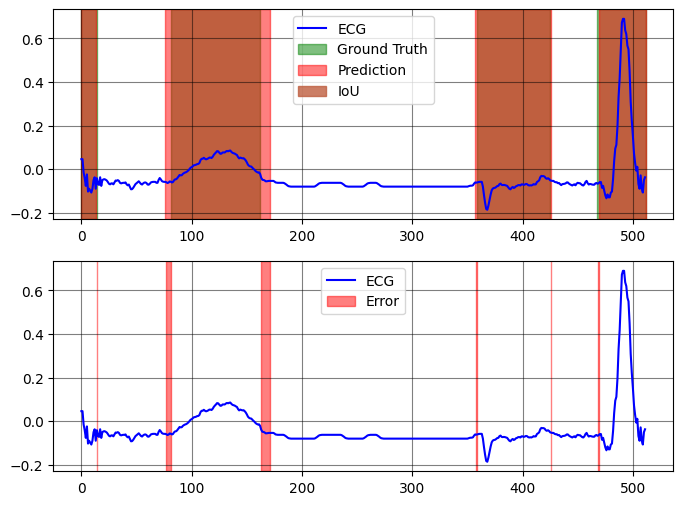

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from customLib.lobachevsky import grouped
# https://github.com/byschii/ecg-segmentation/tree/main 

ecg_index = 150

# plot categories on ecg
signal = x_test[ecg_index]
categories = y_test[ecg_index]
predicted_categories = np.argmax(prediction[ecg_index], axis=1)

# get time point where category changes
time_points = np.where(categories[:-1] != categories[1:])[0]
predicted_time_points = np.where(predicted_categories[:-1] != predicted_categories[1:])[0]

error = get_error_edges(categories, predicted_categories)

print(error)

# chek if category was at beginning or end
if categories[0] != 0:
    # if category was at beginning, add first time point
    time_points = np.append(0, time_points)
if categories[-1] != 0:
    # if category was at end, add last time point
    time_points = np.append(time_points, len(categories))

if predicted_categories[0] != 0:
    # if category was at beginning, add first time point
    predicted_time_points = np.append(0, predicted_time_points)
if predicted_categories[-1] != 0:
    # if category was at end, add last time point
    predicted_time_points = np.append(predicted_time_points, len(predicted_categories))

# plot the signal
fig, axs = plt.subplots(nrows=2)
ax = axs[0]
ax.plot(signal, color="blue")
ax.grid(color="black", alpha=.5)

for b,e in grouped(time_points, 2):
    ax.axvspan(b, e, facecolor='0.5', alpha=0.5, color="green")

for b,e in grouped(predicted_time_points, 2):
    ax.axvspan(b, e, facecolor='0.5', alpha=0.5, color="Red")

green_patch = mpatches.Patch(color='green', alpha=0.5, label='Ground Truth')
prediction_path = mpatches.Patch(color='red', alpha=0.5, label='Prediction')
iou_patch = mpatches.Patch(color='#BE5E3F', alpha=0.8, label='IoU')

# Include the line plot in the legend by using the plot handle
ecg_line, = plt.plot([], [], 'k', label="ECG", color="blue")  # An empty plot with the desired label

ax.legend(handles=[ecg_line, green_patch, prediction_path, iou_patch])

ax = axs[1]
ax.plot(signal, color="blue")
for b,e in grouped(error, 2):
    ax.axvspan(b, e, facecolor='0.5', alpha=0.5, color="red")

error_patch = mpatches.Patch(color='red', alpha=0.5, label='Error')

ax.grid(color="black", alpha=.5)
ax.legend(handles=[ecg_line, error_patch])

fig.set_size_inches(8,6)

In [ ]:
# https://github.com/byschii/ecg-segmentation/tree/main 

def find_wave_onset(wave_category:list) -> np.ndarray:
    """
    Check where the wave starts
    """
    onsets = []
    prev = None
    for i, val in enumerate(wave_category):
        if val != 0 and prev == 0:
            onsets.append(i)
        prev = val
    return np.array(onsets)

def find_wave_offset(wave_category:list) -> np.ndarray:
    """
    Check where the wave ends
    """
    offsets = []
    prev = None
    for i, val in enumerate(wave_category):
        if val == 0 and prev != 0:
            offsets.append(i)
        prev = val
    return np.array(offsets)

def get_probably_matching_timepoints(shorter:np.ndarray, longer:np.ndarray):
    indices_minimizind_distancies = [
        np.argmin(row) for row in np.abs(np.subtract.outer(shorter, longer))
    ]
    return longer[indices_minimizind_distancies]


def get_true_false_errs_from_mismatching_timepoints(shorter:np.ndarray, longer:np.ndarray, toll:int):
    if len(shorter) == 0:
        return len(longer), 0, []

    falses = len(longer) - len(shorter)

    matched_longer = get_probably_matching_timepoints(shorter, longer)

    dists = np.abs(matched_longer - shorter)

    trues = np.sum(dists <= toll)
    errs = list(dists[dists < toll])

    return falses, trues, errs 


WAVE_TO_COLUMN = {
    "None": 0,
    "P":3,
    "QRS":1,
    "T":2,
}

WAVE_DATA = {
    "None": None,
    "P": {},
    "QRS": {},
    "T": {},
}

EXTRA_WAVE_DATA = {
    "None": {},
    "P": {},
    "QRS": {},
    "T": {},
}

In [187]:
toll = 75

F1 = BinaryF1Score()
conf_matrics = ConfusionMatrix(task="binary", num_classes=2)

for wave_name, column_index in WAVE_TO_COLUMN.items():
    if column_index == 0:
        continue
    print("Checking", wave_name)
    for phase, time_point_function in zip(["onset", "offset"],[find_wave_onset, find_wave_offset]):

        evaluation = {
            "TP": 0,
            "FP": 0,
            "FN": 0,
            "errors": [],
            "mean_iou": JaccardIndex(task="binary"),
            "confusion_matrix": torch.tensor([[0,0],[0,0]]),
            "F1_score": 0,
            "TPR": 0,
            "FPR": 0,
            "TNR": 0,
            "FNR": 0,
            "mean_iou": JaccardIndex(task="binary")
        }


        for gt, y_pred in zip(y_test, prediction):
            wave_test = (gt == column_index).astype(int)                        # we kinda switch to binary classification problem -> we check for one wave type at a time
            wave_pred = (np.argmax(y_pred, axis=1) == column_index).astype(int) # both of shape (num_timesteps, )

            wave_test_points = time_point_function(wave_test)
            wave_pred_points = time_point_function(wave_pred)

            try:
                if len(wave_test_points) == len(wave_pred_points):
                    # i ASSUME that wave match and that there might be true positives
                    # still have to if correspoding points are in the tollerance
                    _, trues, errs = get_true_false_errs_from_mismatching_timepoints(wave_test_points, wave_pred_points, toll)
                    evaluation["TP"] += trues
                    evaluation["errors"] += errs
                    
                elif len(wave_test_points) > len(wave_pred_points):
                    # if 'wave_test_points' is longer i have false negatives
                    falses, trues, errs = get_true_false_errs_from_mismatching_timepoints(wave_pred_points, wave_test_points, toll)
                    evaluation["TP"] += trues
                    evaluation["FN"] += falses
                    evaluation["errors"] += errs

                elif len(wave_test_points) < len(wave_pred_points):
                    # if 'wave_pred_points' is longer i have false positives
                    falses, trues, errs = get_true_false_errs_from_mismatching_timepoints(wave_test_points, wave_pred_points, toll)

                    evaluation["TP"] += trues
                    evaluation["FP"] += falses
                    evaluation["errors"] += errs
            except Exception as e:
                print(wave_test_points, wave_pred_points, len(wave_test_points), len(wave_pred_points))
                raise e

            wave_test = torch.from_numpy(wave_test)
            wave_pred = torch.from_numpy(wave_pred)
            evaluation["mean_iou"].update(wave_pred, wave_test)
            evaluation["confusion_matrix"] += conf_matrics(wave_pred, wave_test)

        evaluation["F1_score"] /= y_test.shape[0] # average over all examples
        tp = evaluation["confusion_matrix"][0][0].item()
        tn = evaluation["confusion_matrix"][1][1].item()
        fp = evaluation["confusion_matrix"][0][1].item()
        fn = evaluation["confusion_matrix"][1][0].item()

        evaluation["TPR"] = tp / (tp + fn) if (tp + fn) > 0 else 0
        evaluation["FPR"] = fp / (fp + tn) if (fp + tn) > 0 else 0
        evaluation["TNR"] = tn / (tn + fp) if (tn + fp) > 0 else 0
        evaluation["FNR"] = fn / (fn + tp) if (fn + tp) > 0 else 0

        WAVE_DATA[wave_name][phase] = evaluation


Checking P
Checking QRS
Checking T


In [ ]:
for wave_name, _ in WAVE_DATA.items():
    if wave_name == "None":
        continue
    print(f"{wave_name} mean_iou onset: ", WAVE_DATA[wave_name]["onset"]["mean_iou"].compute())
    print(f"{wave_name} mean_iou offset: ", WAVE_DATA[wave_name]["offset"]["mean_iou"].compute(), "\n")

for wave_name, _ in WAVE_DATA.items():
    if wave_name == "None":
        continue
    print(f"{wave_name} Average F1_score onset: ", WAVE_DATA[wave_name]["onset"]["F1_score"].item())
    print(f"{wave_name} Average F1_score offset: ", WAVE_DATA[wave_name]["offset"]["F1_score"].item(), "\n")

for wave_name, _ in WAVE_DATA.items():
    if wave_name == "None":
        continue
    print(f"{wave_name} Average F1_score onset: ", WAVE_DATA[wave_name]["onset"]["F1_score"])
    print(f"{wave_name} Average F1_score offset: ", WAVE_DATA[wave_name]["offset"]["F1_score"], "\n")

In [37]:
metric = MulticlassJaccardIndex(num_classes=4, average=None)

for gt, y_pred in zip(y_test, prediction):
    y_pred_indices = np.argmax(y_pred, axis=1)
    metric.update(torch.from_numpy(gt), torch.from_numpy(y_pred_indices))

metric.compute()


tensor([0.7408, 0.7979, 0.5596, 0.5563])